## Uvod

V tej nalogi obravnavamo časovno-frekvenčno analizo govornih signalov s pomočjo kratkočasovne Fourierove transformacije (STFT). Cilj analize je raziskati, kako se frekvenčna vsebina govora spreminja skozi čas, pri čemer nas zanimajo vplivi dolžine časovnega okna in stopnje prekrivanja na zaznavanje višjih harmonikov, razlikovanje med samoglasniki in sledenje nestacionarnosti pri različnih hitrostih izgovarjave.

STFT smo izvedli s funkcijo, ki omogoča nastavitev dolžine intervala, prekrivanja in uporabo Hammingovega okna. Analizo smo izvedli na lastnih zvočnih posnetkih slovenskih samoglasnikov in besed z različnimi govornimi značilnostmi.


In [70]:
import os
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

audio_folder = '3s'

signals = {}

for filename in os.listdir(audio_folder):
    if filename.endswith('.wav'):
        name = os.path.splitext(filename)[0]
        filepath = os.path.join(audio_folder, filename)
        
        data, samplerate = sf.read(filepath)
        signals[name] = (data, samplerate)
        
        print(f"Loaded '{name}': {len(data)} samples at {samplerate} Hz")

print(f"\nTotal files loaded: {len(signals)}")


Loaded 'o_low': 132300 samples at 44100 Hz
Loaded 'a_high': 132300 samples at 44100 Hz
Loaded 'erozija_1': 132300 samples at 44100 Hz
Loaded 'whisper_1': 132300 samples at 44100 Hz
Loaded 'erozija_2': 132300 samples at 44100 Hz
Loaded 'whisper_2': 132300 samples at 44100 Hz
Loaded 'o_high': 132300 samples at 44100 Hz
Loaded 'i_low': 132300 samples at 44100 Hz
Loaded 'a_low': 132300 samples at 44100 Hz
Loaded 'i_high': 132300 samples at 44100 Hz

Total files loaded: 10


In [20]:

def stft_custom(signal, sample_rate, window_ms=20, overlap_pct=0.5, use_hamming=False):
    window_size = int(window_ms * sample_rate / 1000)
    hop_size = int(window_size * (1 - overlap_pct))
    
    total_frames = int(np.ceil((len(signal) - window_size) / hop_size)) + 1
    pad_length = (total_frames - 1) * hop_size + window_size
    padded_signal = np.pad(signal, (0, pad_length - len(signal)))
    
    window = np.hamming(window_size) if use_hamming else np.ones(window_size)
    
    spectrogram = []
    for start in range(0, len(padded_signal) - window_size + 1, hop_size):
        frame = padded_signal[start:start + window_size] * window
        spectrum = np.fft.rfft(frame)
        magnitude = np.abs(spectrum)
        spectrogram.append(magnitude)
    
    return np.array(spectrogram).T

In [59]:
def plot_stft(signal, sr, key, window_ms=20, overlap_pct=0.5, freq_limit=750):
    if signal.ndim > 1:
        signal = signal[:, 0]

    spec_no_window = stft_custom(signal, sr, window_ms, overlap_pct, use_hamming=False)
    spec_hamming = stft_custom(signal, sr, window_ms, overlap_pct, use_hamming=True)

    spec_no_window_mag = np.abs(spec_no_window)
    spec_hamming_mag = np.abs(spec_hamming)

    n_frames = spec_no_window.shape[1]
    frame_hop = int((1 - overlap_pct) * window_ms * sr / 1000)
    frame_times = np.arange(n_frames) * frame_hop / sr
    freqs = np.fft.rfftfreq(int(window_ms * sr / 1000), d=1/sr)

    freq_indices = freqs <= freq_limit
    freqs = freqs[freq_indices]
    spec_no_window_mag = spec_no_window_mag[freq_indices, :]
    spec_hamming_mag = spec_hamming_mag[freq_indices, :]

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    pcm0 = axes[0].pcolormesh(frame_times, freqs, spec_no_window_mag, shading='auto', cmap='magma')
    axes[0].set_title(f"STFT of '{key}' WITHOUT Hamming window ({window_ms} ms, {int(overlap_pct*100)}% overlap)")
    axes[0].set_ylabel("Frequency (Hz)")
    fig.colorbar(pcm0, ax=axes[0], label='Amplitude')

    pcm1 = axes[1].pcolormesh(frame_times, freqs, spec_hamming_mag, shading='auto', cmap='magma')
    axes[1].set_title(f"STFT of '{key}' WITH Hamming window ({window_ms} ms, {int(overlap_pct*100)}% overlap)")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Frequency (Hz)")
    fig.colorbar(pcm1, ax=axes[1], label='Amplitude')

    plt.tight_layout()
    plt.show()

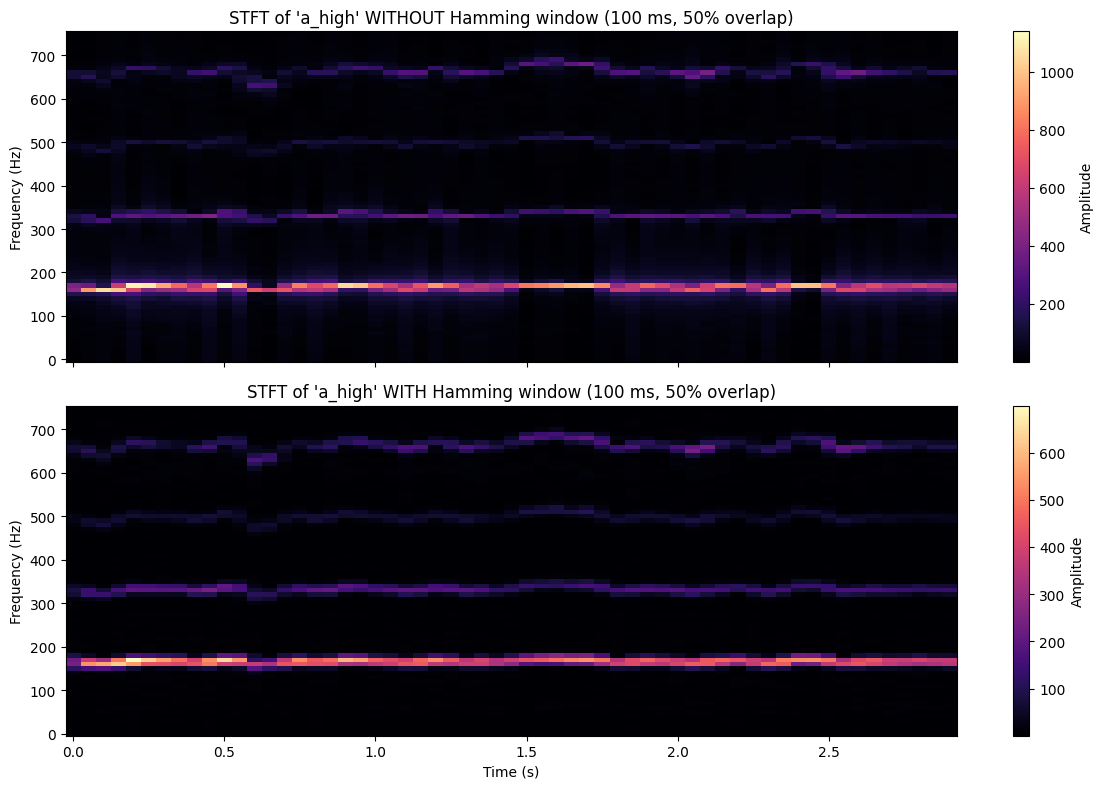

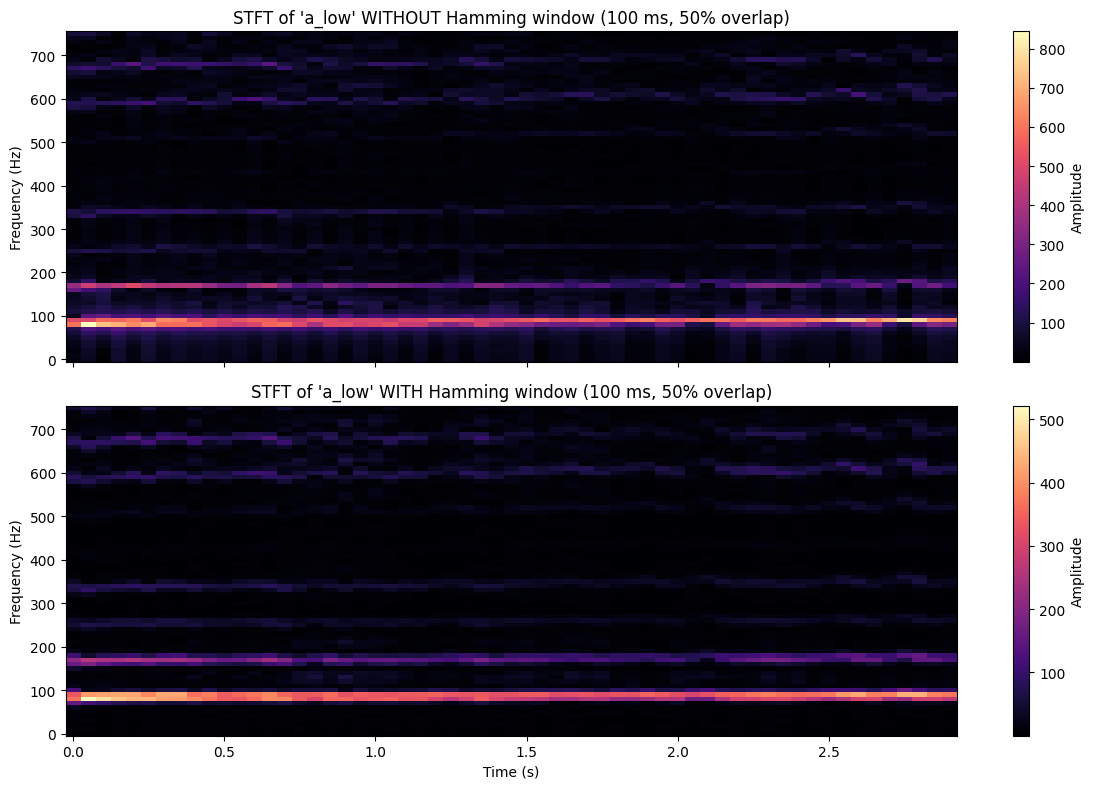

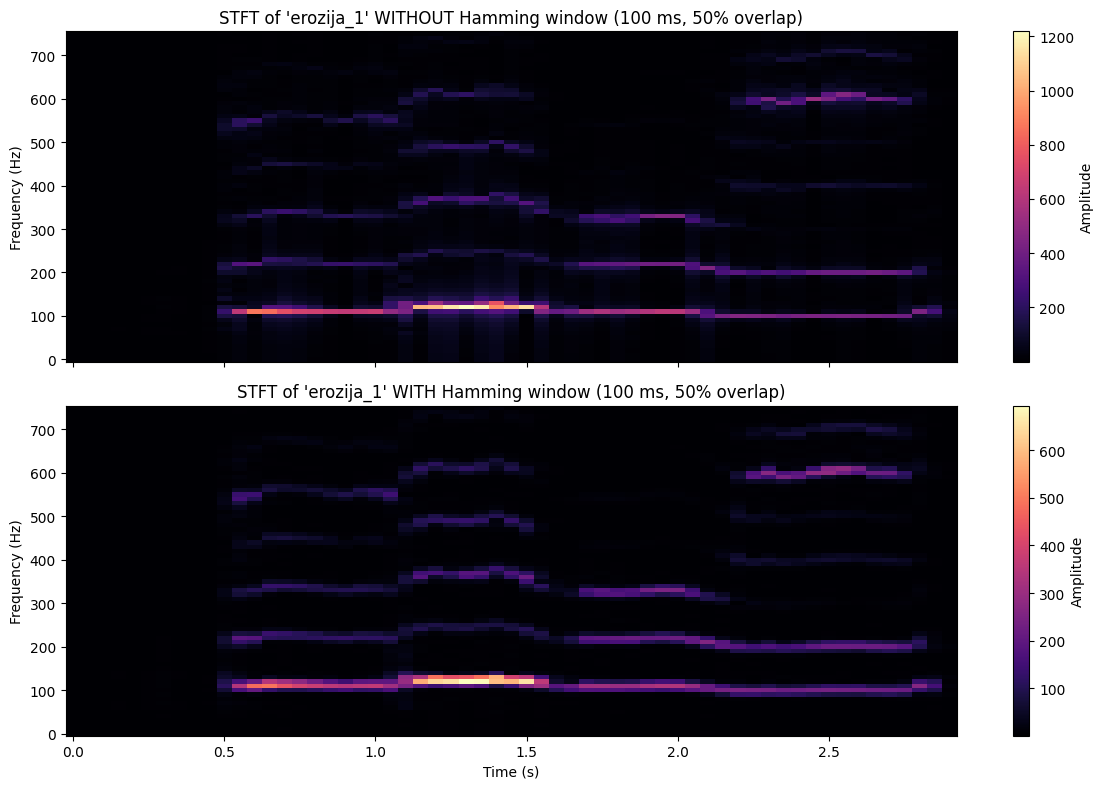

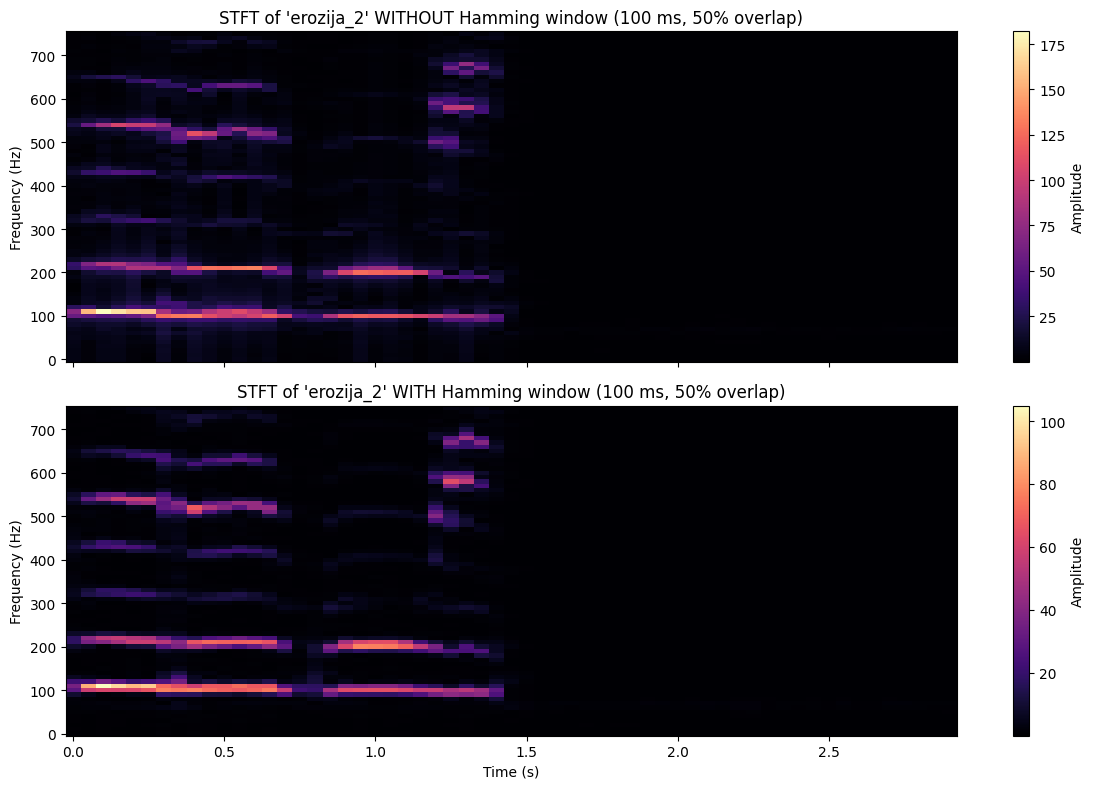

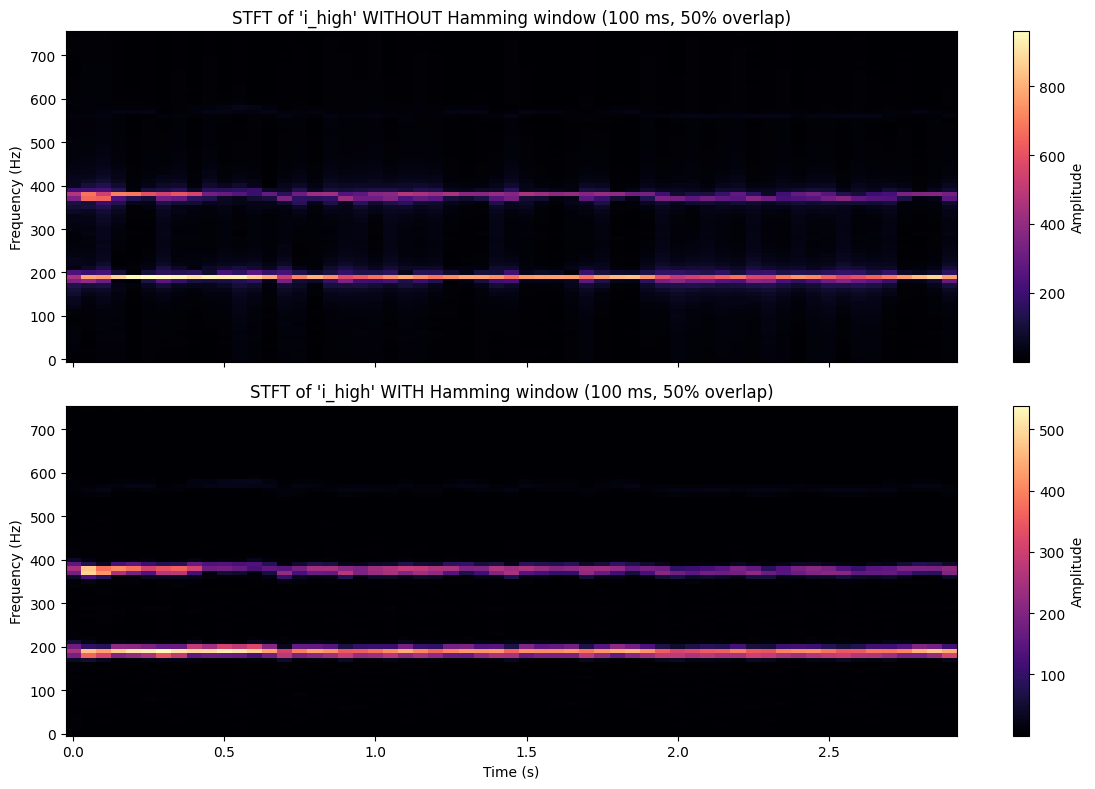

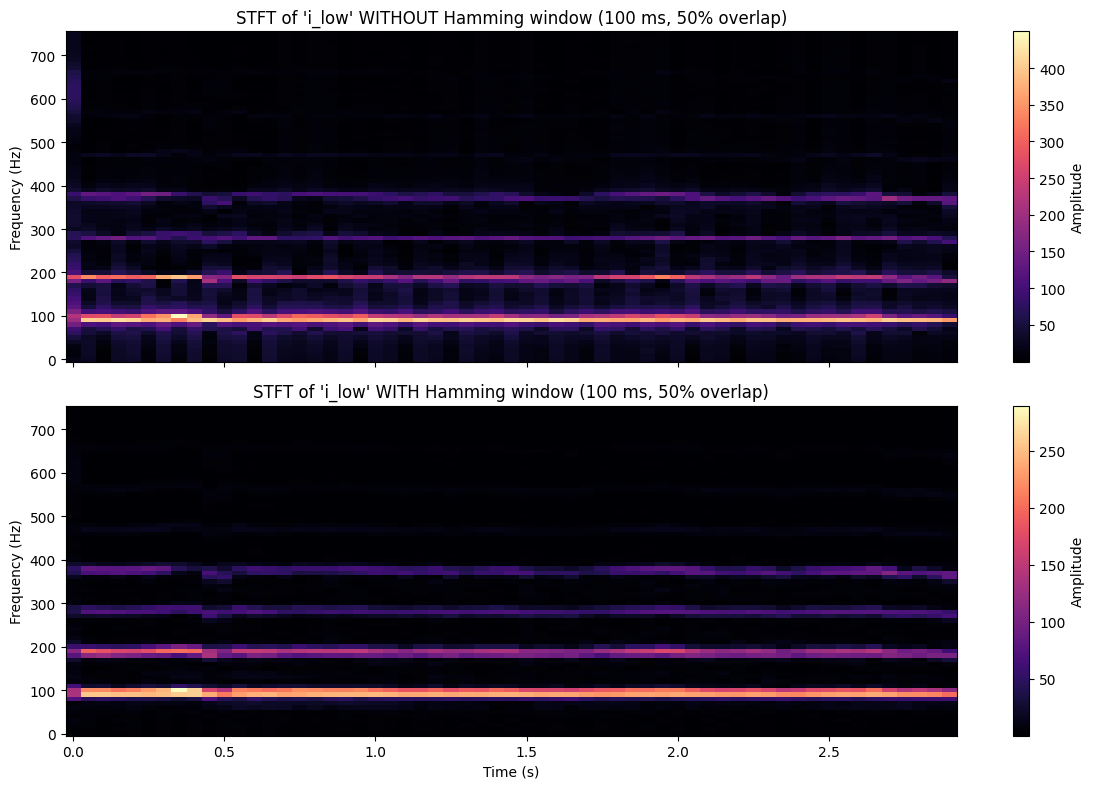

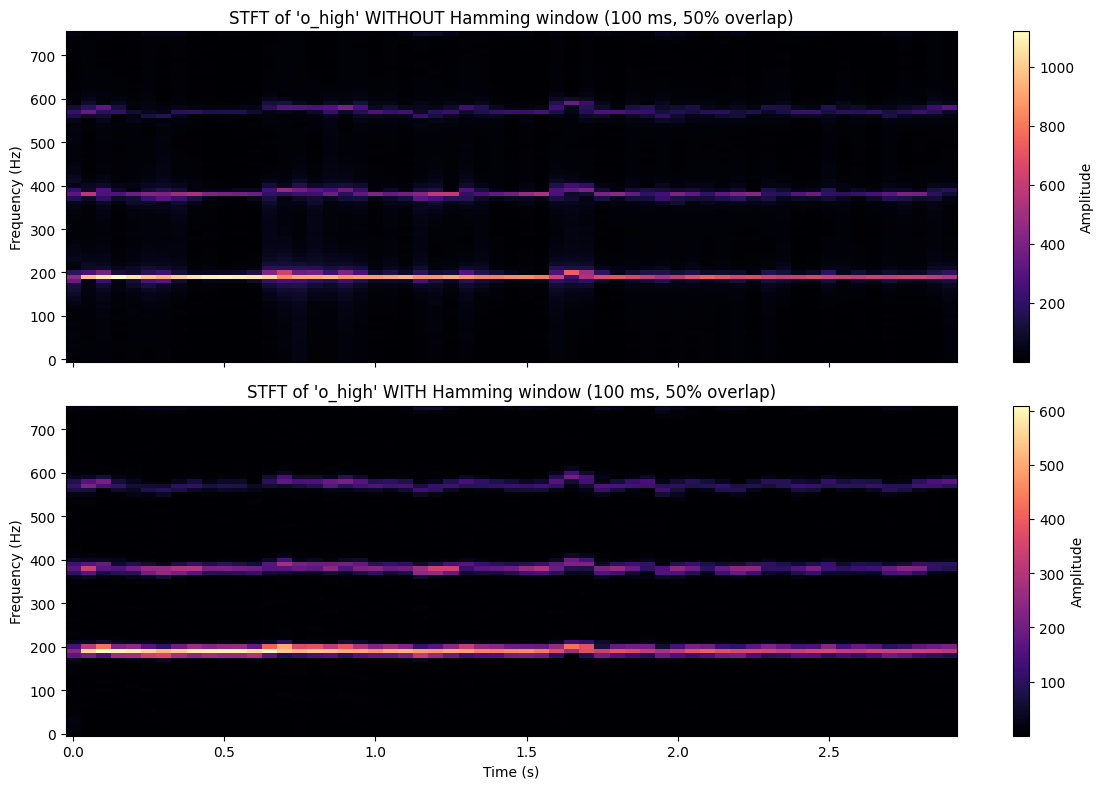

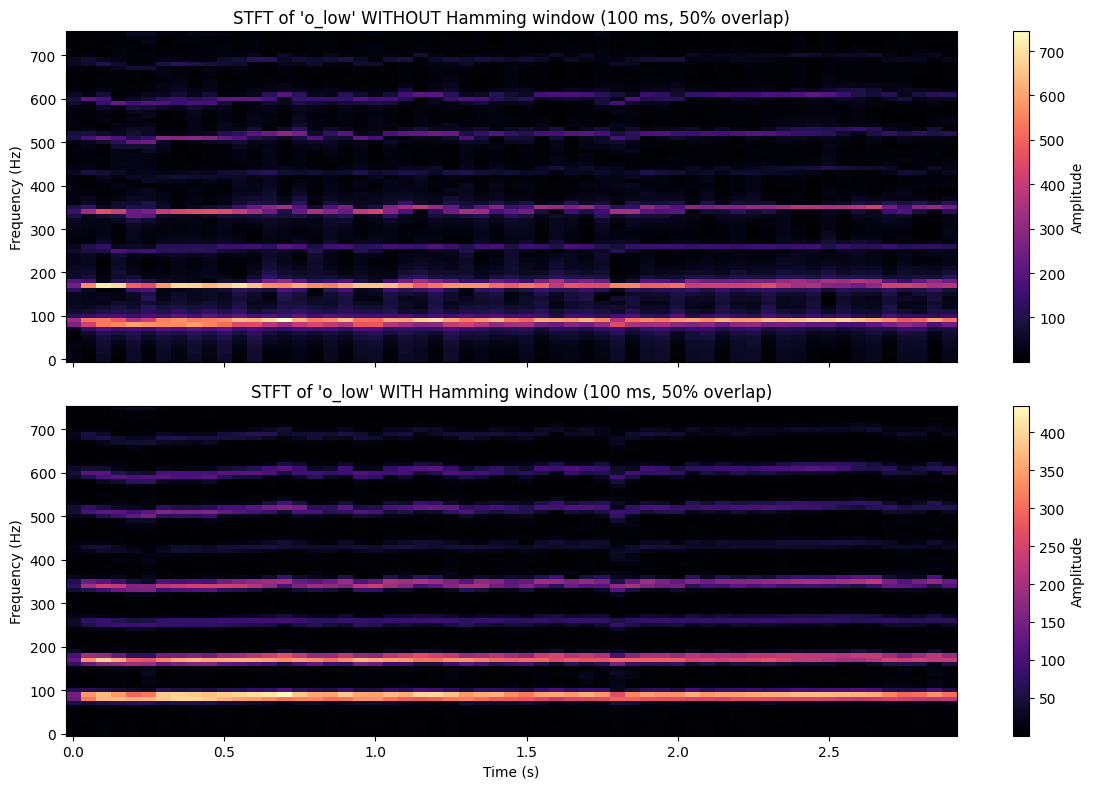

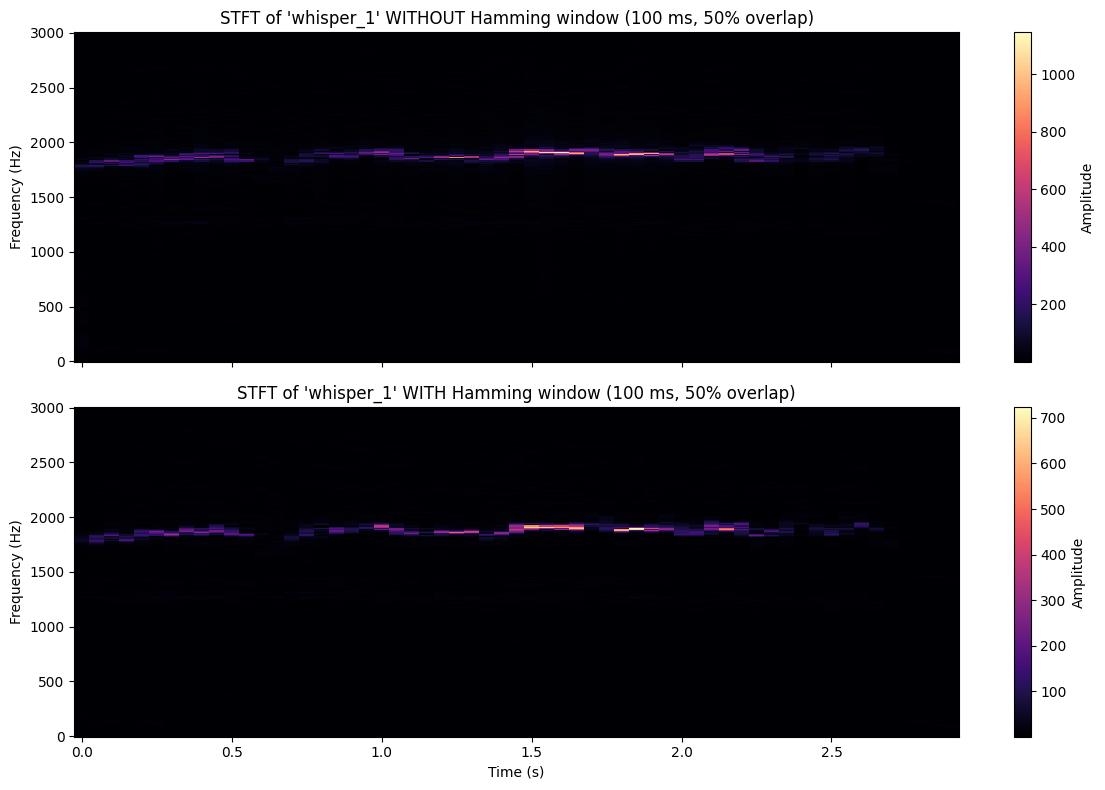

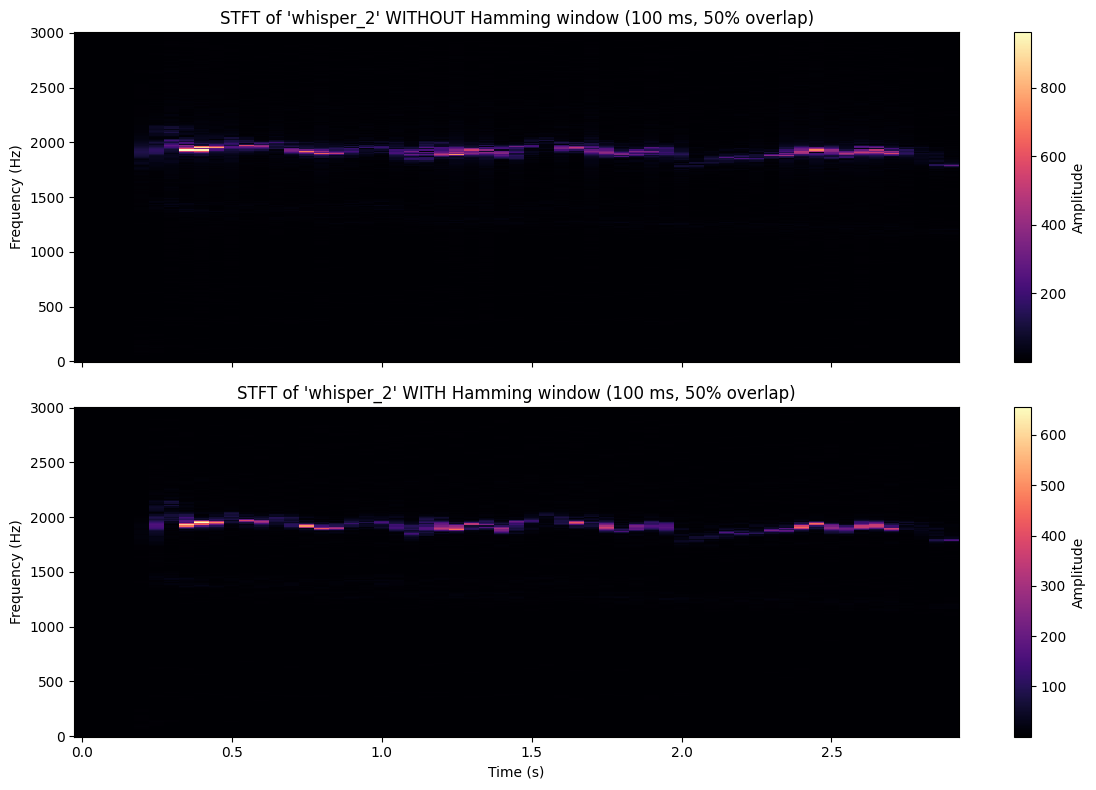

In [71]:
for key in sorted(signals.keys()):
    signal, sr = signals[key]
    
    if key in ["whisper_1", "whisper_2"]:
        freq_limit = 3000
    else:
        freq_limit = 750

    plot_stft(signal, sr, key, window_ms=100, overlap_pct=0.5, freq_limit=freq_limit)


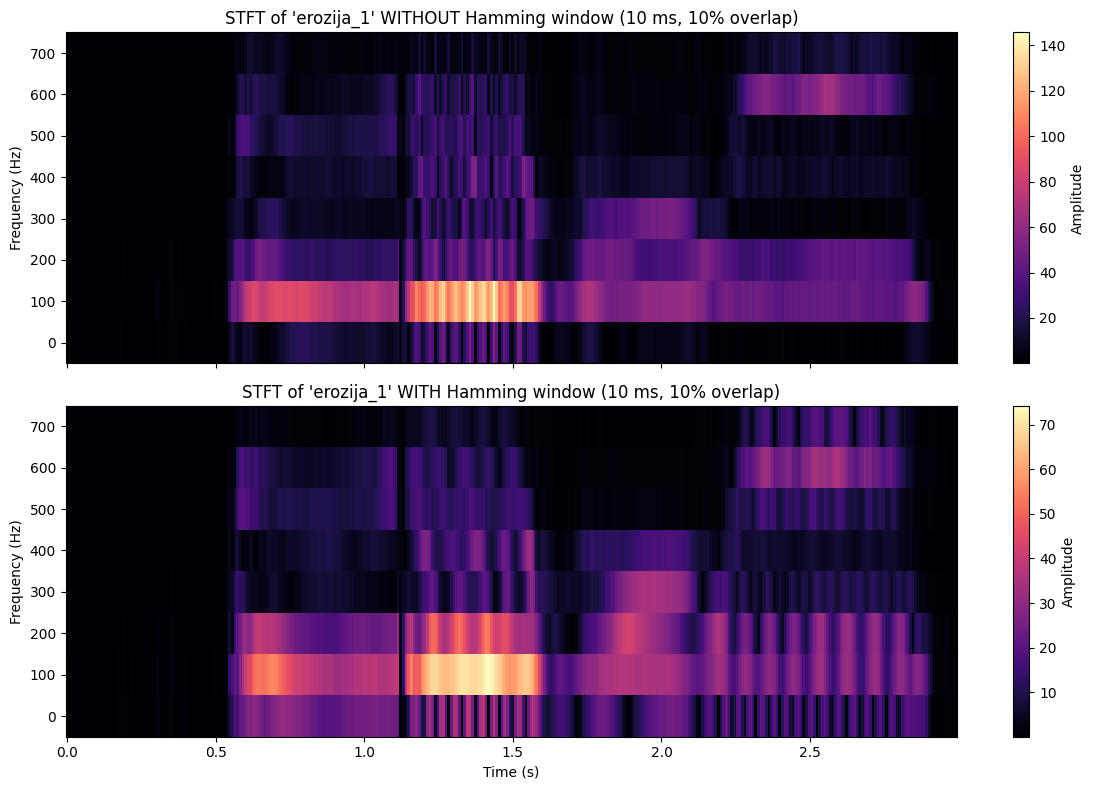

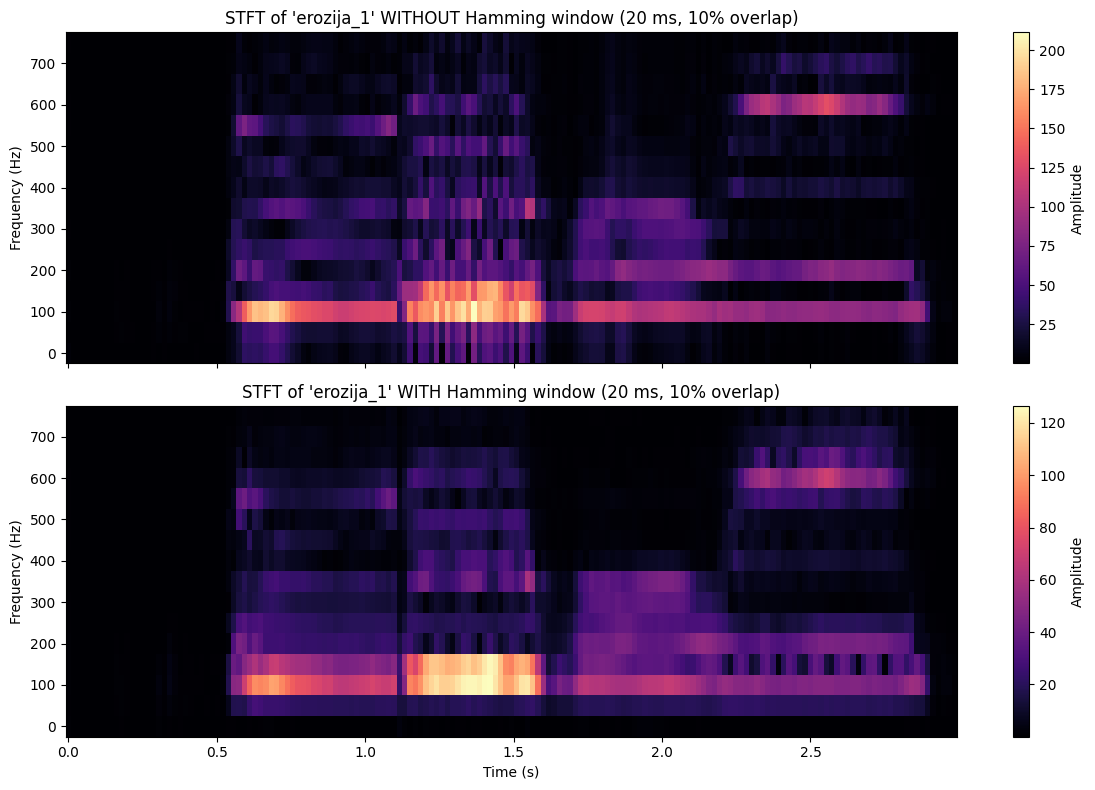

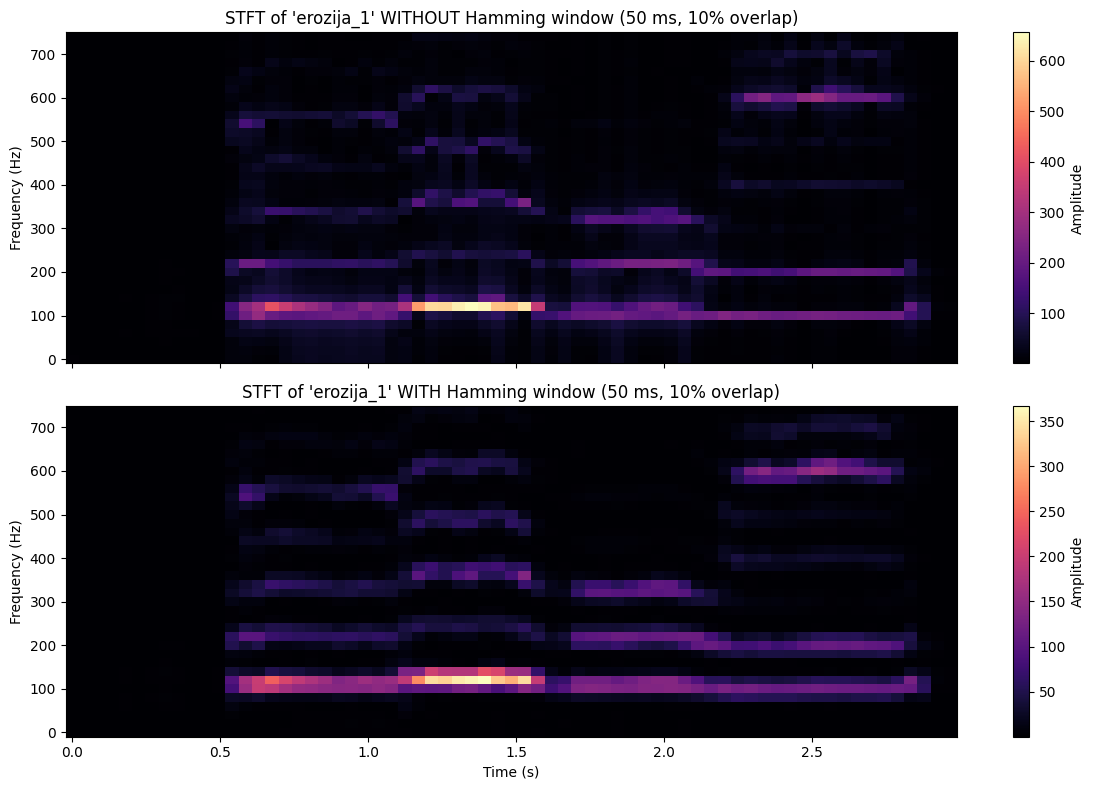

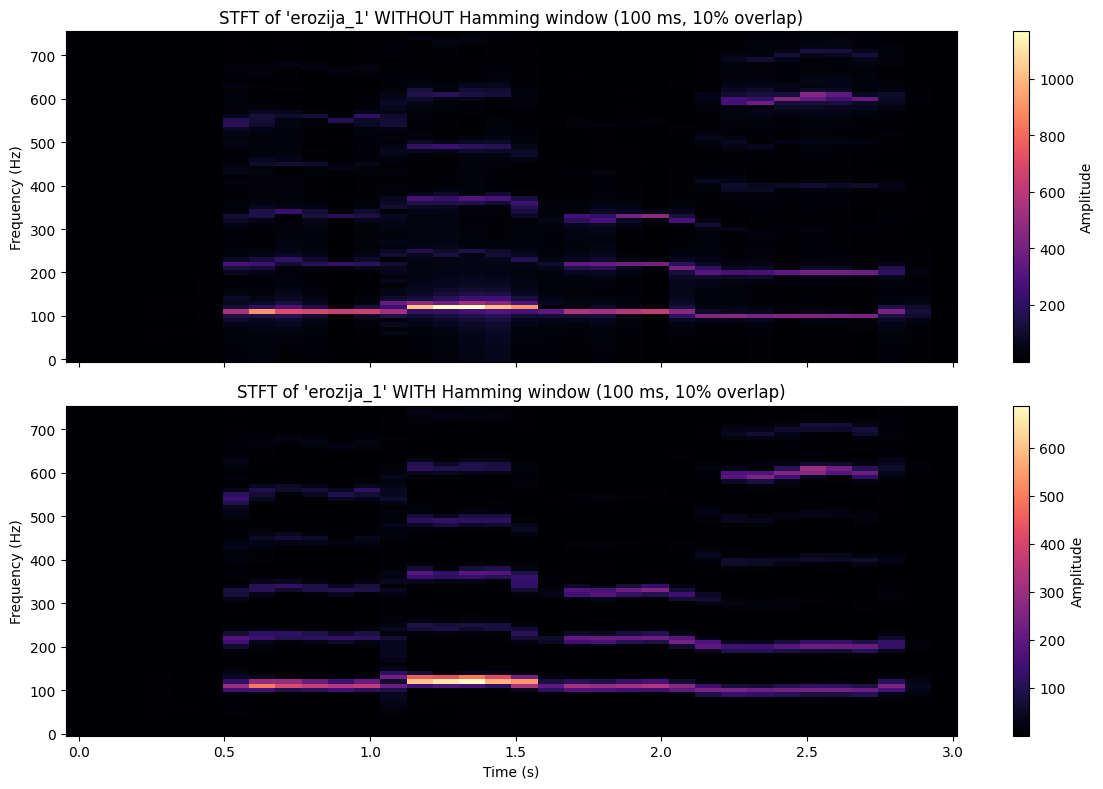

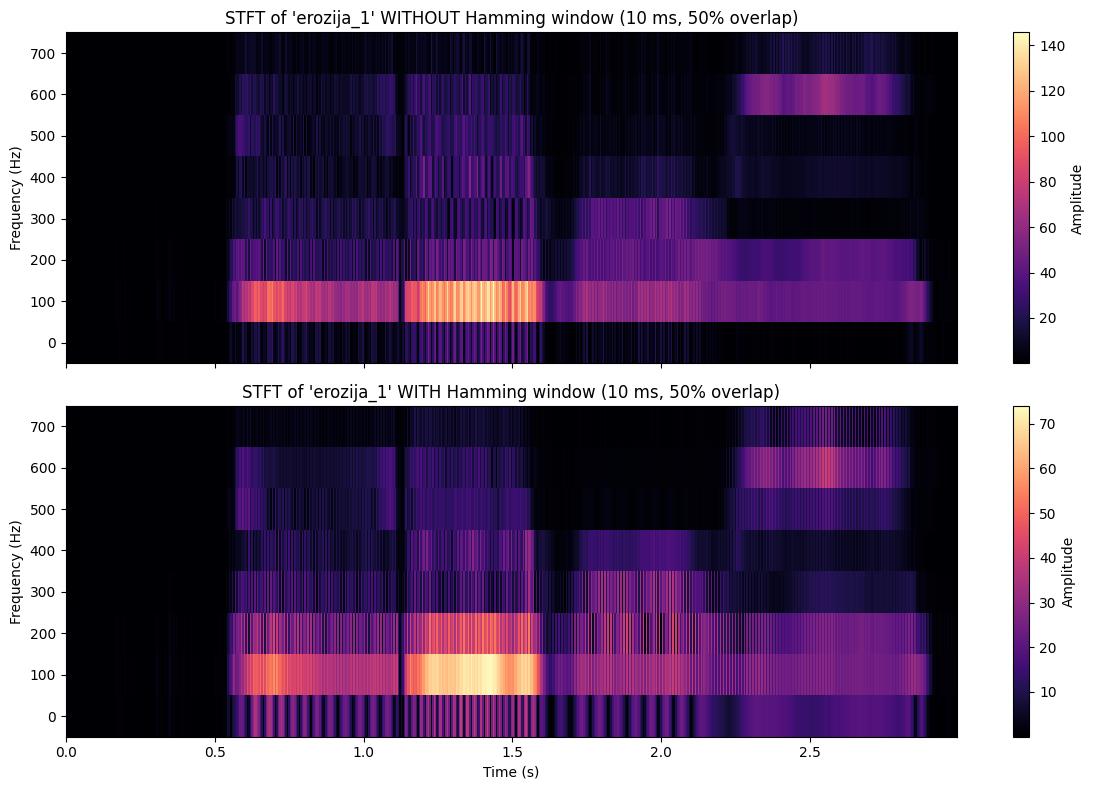

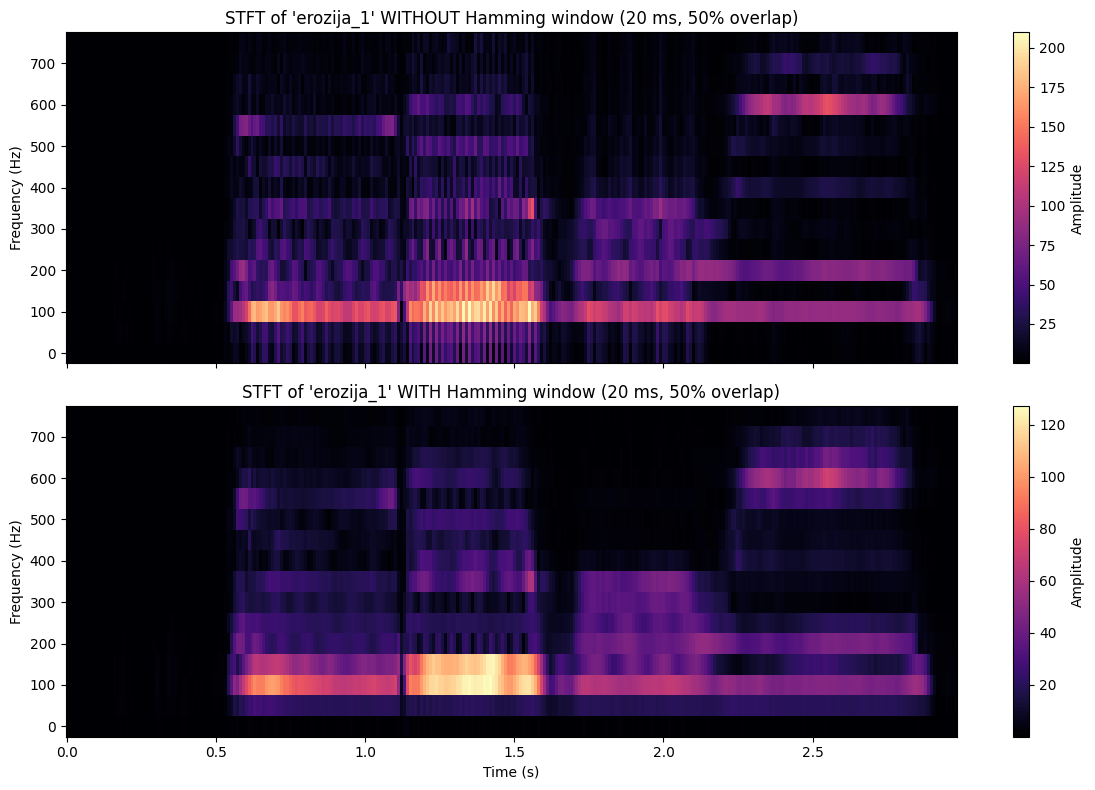

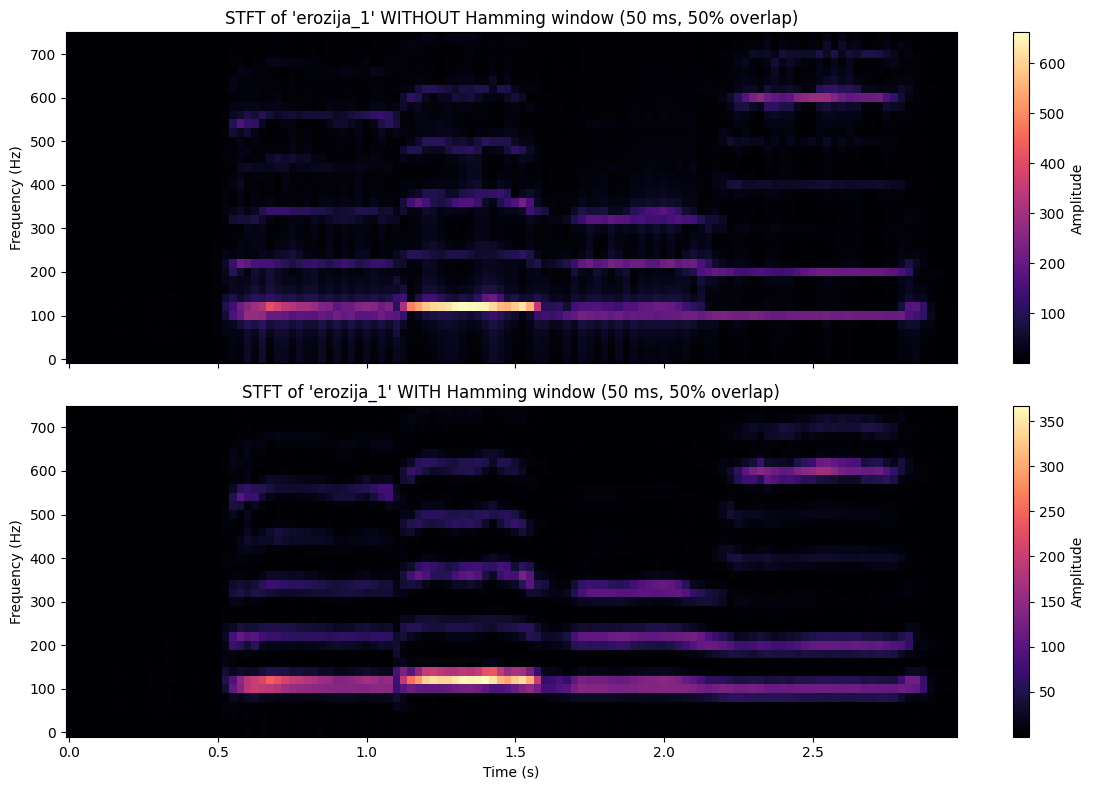

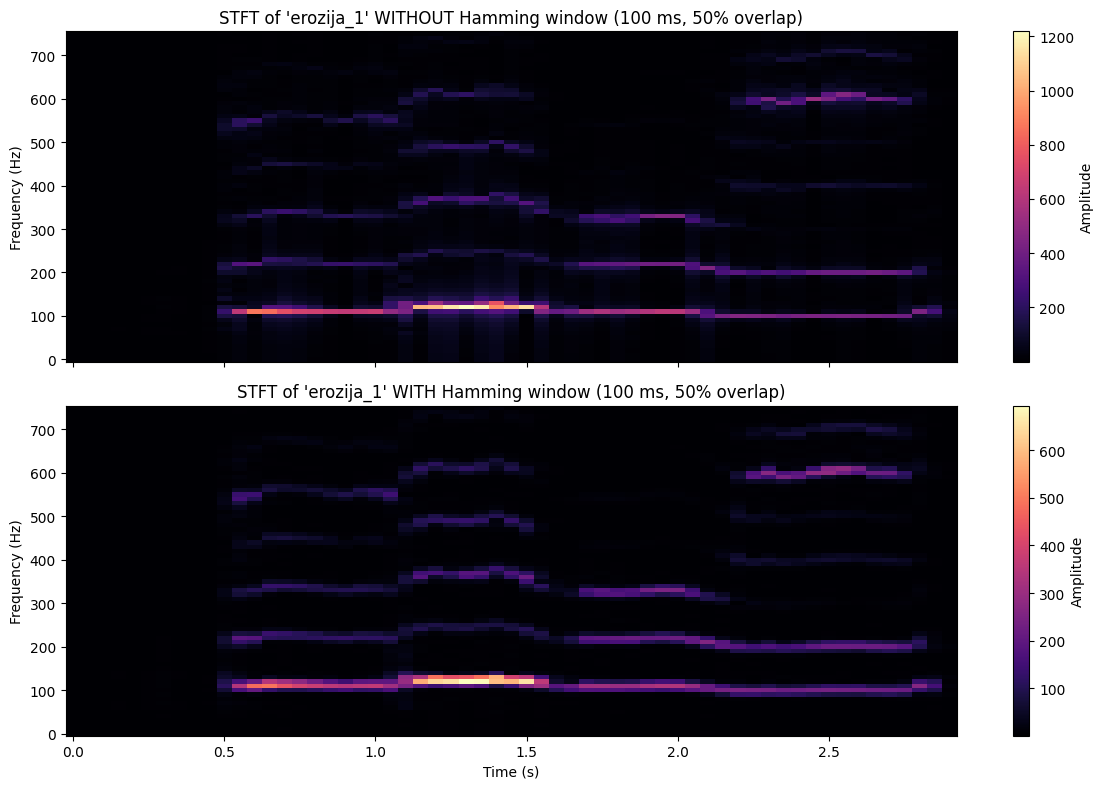

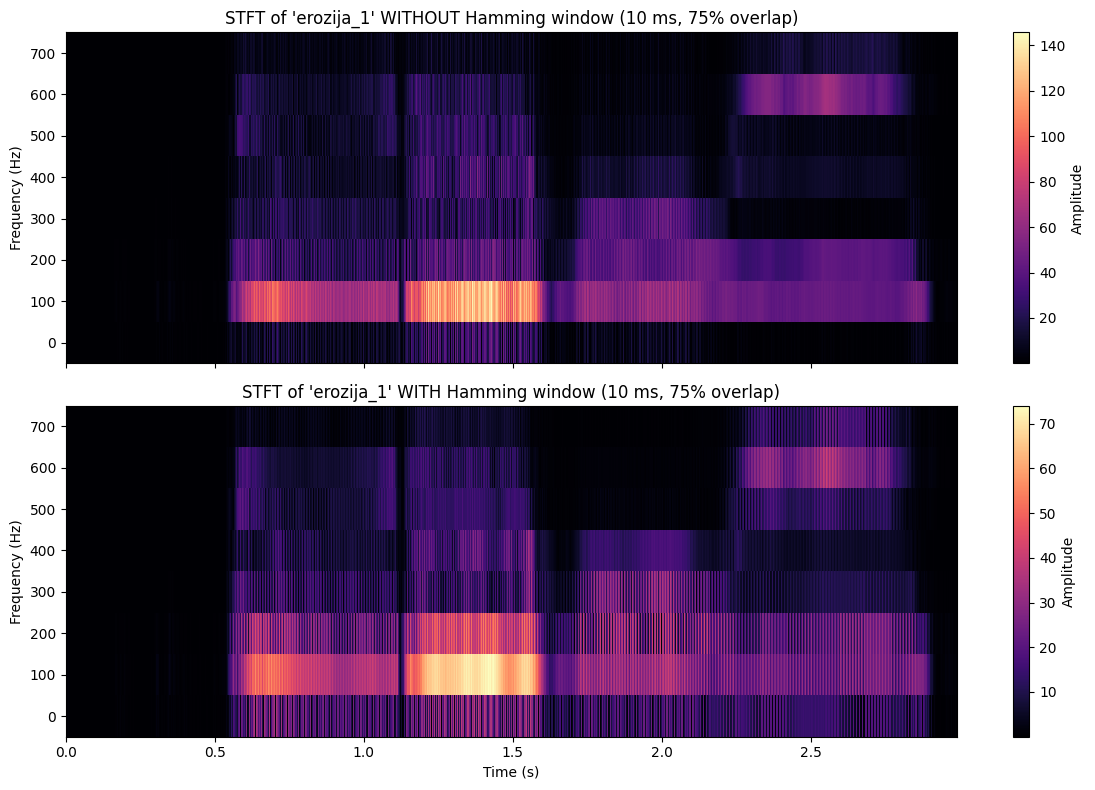

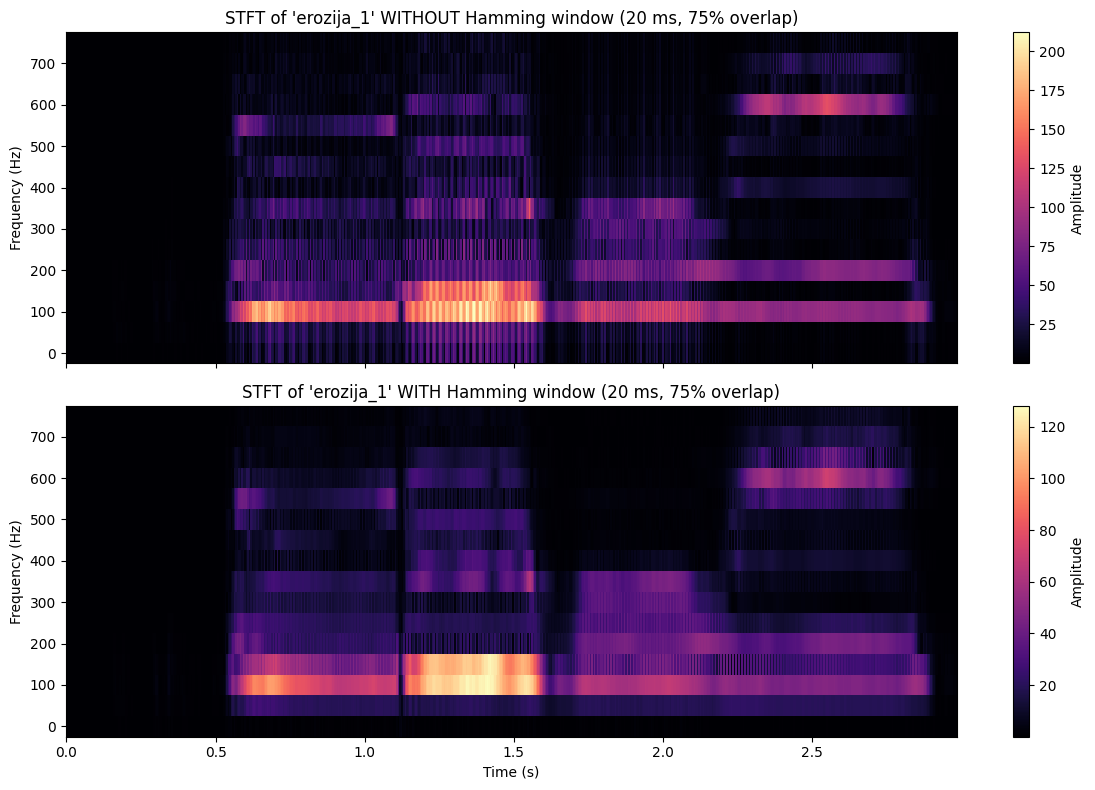

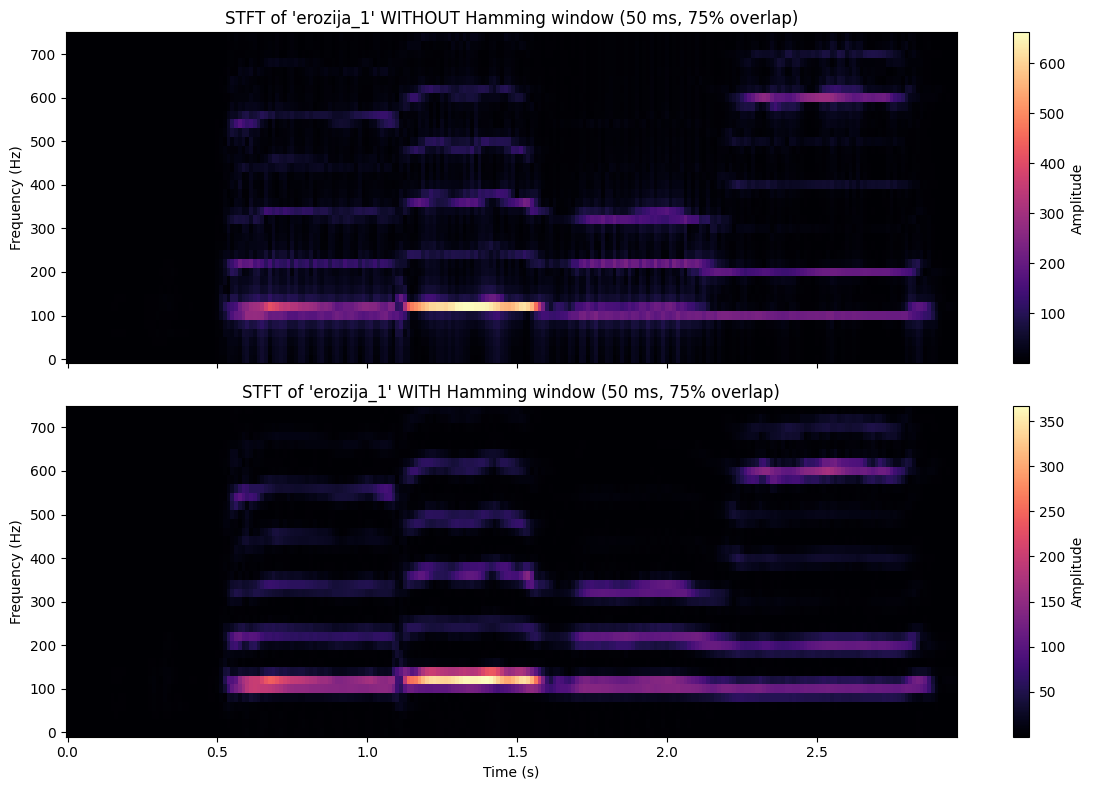

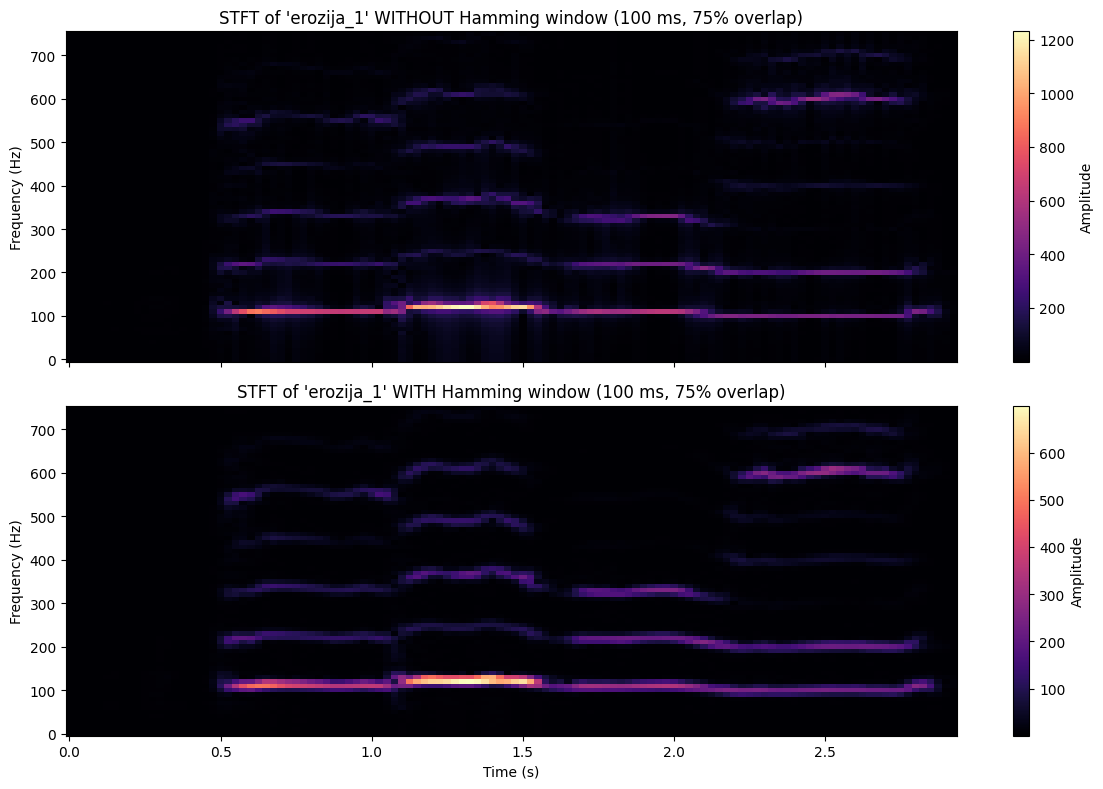

In [72]:
freq_limit = 750
overlap_pcts = [0.1, 0.5, 0.75]
window_mss = [10, 20, 50, 100]


for overlap_pct in overlap_pcts:
    for window_ms in window_mss:
        key = "erozija_1"
        signal, sr = signals[key]
        
        plot_stft(signal, sr, key, window_ms=window_ms, overlap_pct=overlap_pct, freq_limit=750)


### 1. Vpliv hitrosti izgovarjave na dolžino intervalov in prekrivanje
Čeprav teorija pravi, da hitrejša izgovarjava zahteva krajše intervale STFT in večje prekrivanje za zaznavo nestacionarnosti, praksa pokaže, da se zaradi podobnih frekvenc med glasovi krajša okna ne izkažejo kot bistveno boljša — hkrati pa povzročijo izgubo frekvenčne ločljivosti.

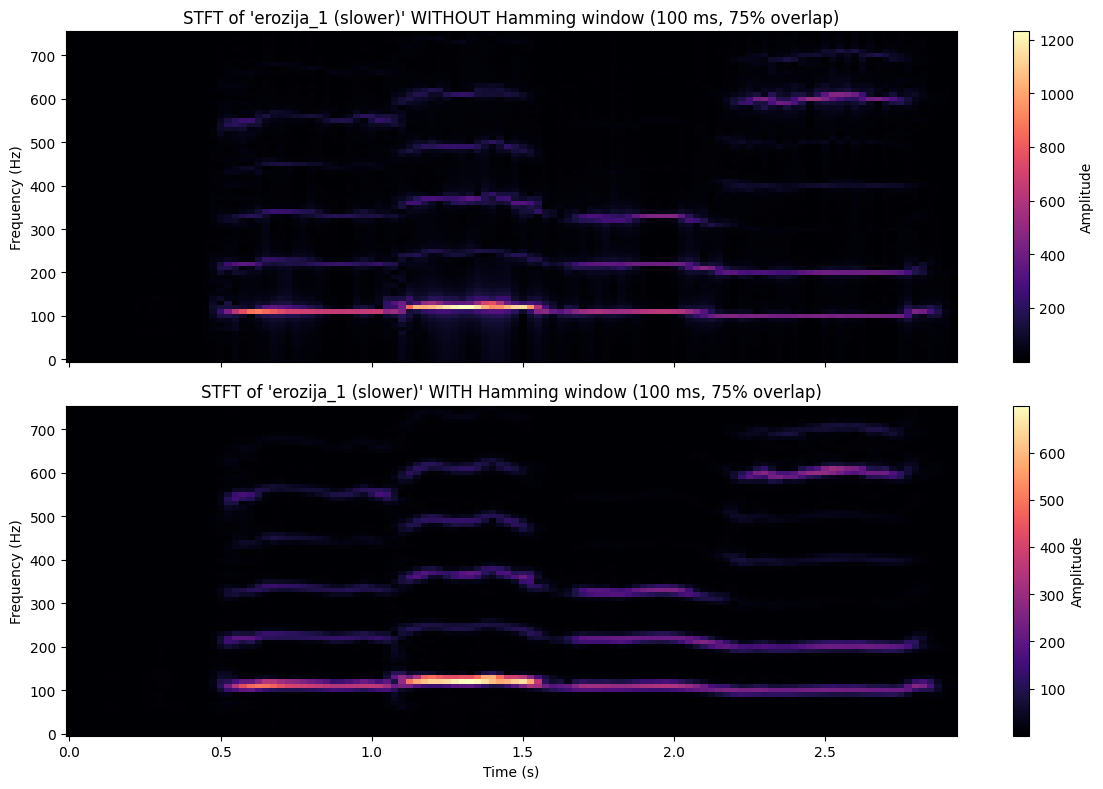

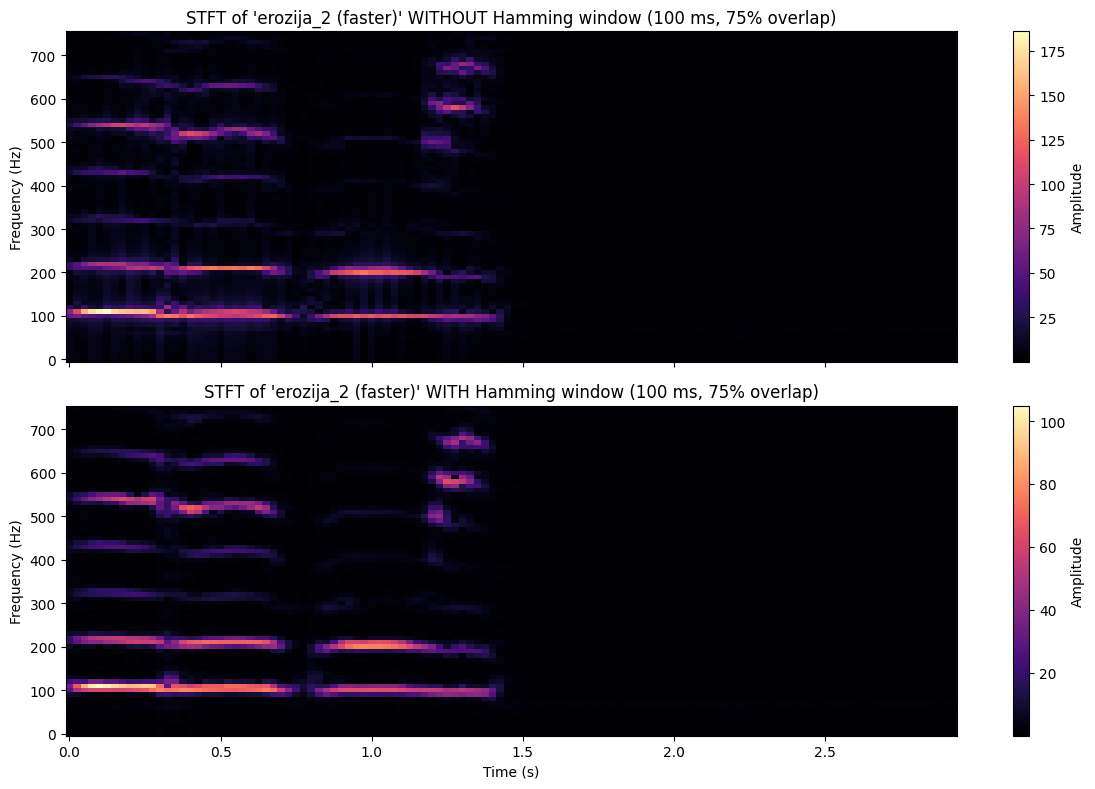

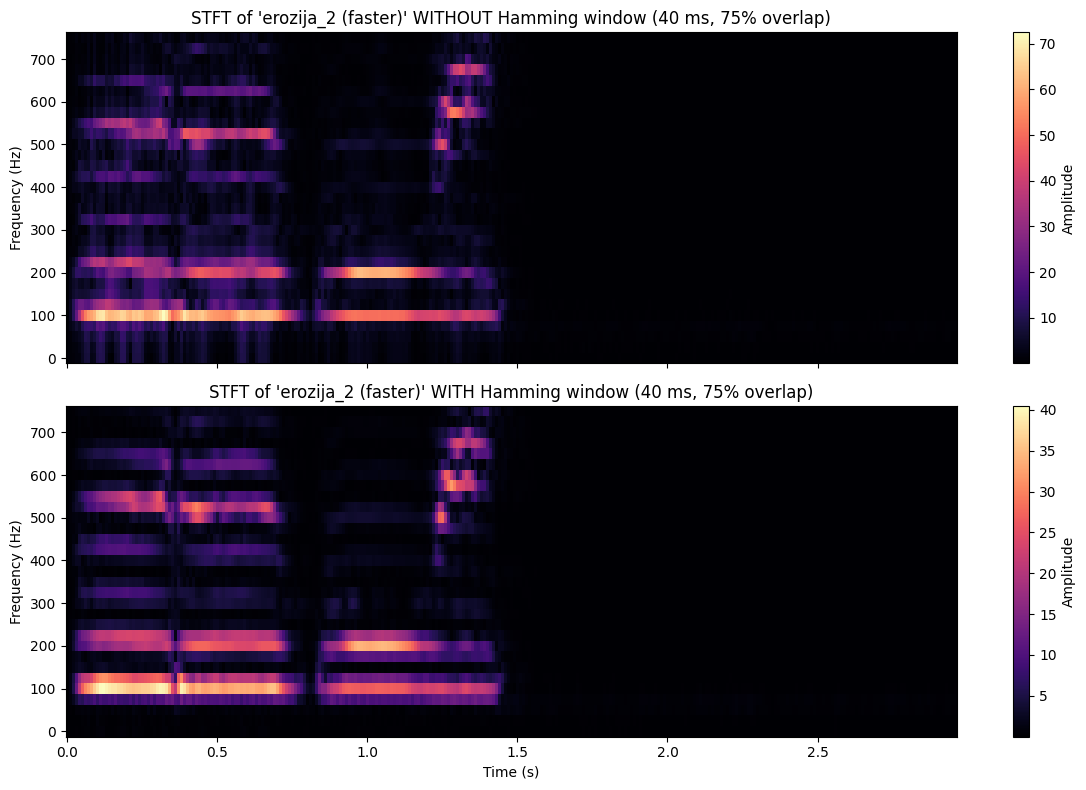

In [78]:
plot_stft(*signals["erozija_1"], "erozija_1 (slower)", window_ms=100, overlap_pct=0.75)
plot_stft(*signals["erozija_2"], "erozija_2 (faster)", window_ms=100, overlap_pct=0.75)
plot_stft(*signals["erozija_2"], "erozija_2 (faster)", window_ms=40, overlap_pct=0.75)


### 2. Vpliv dolžine intervalov na zaznavo višjih harmonikov
Daljši intervali za STFT izboljšajo frekvenčno ločljivost, zaradi česar so višji harmoniki v vztrajnih samoglasnikih bolj vidni.

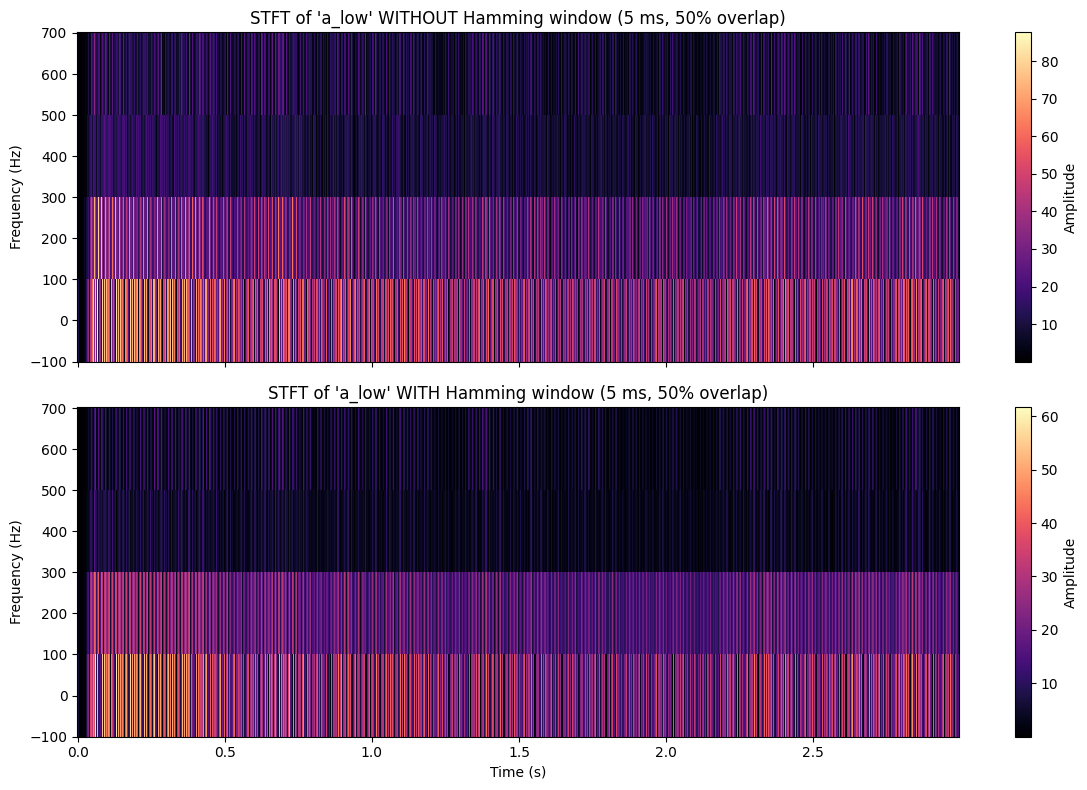

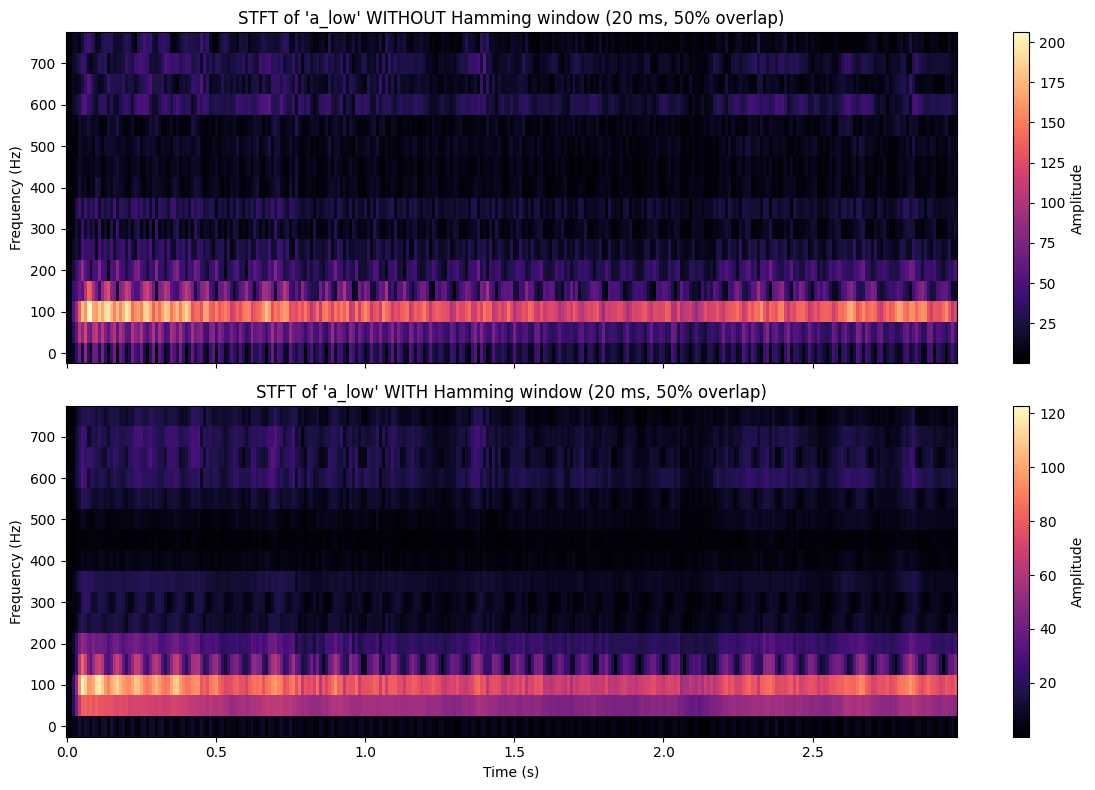

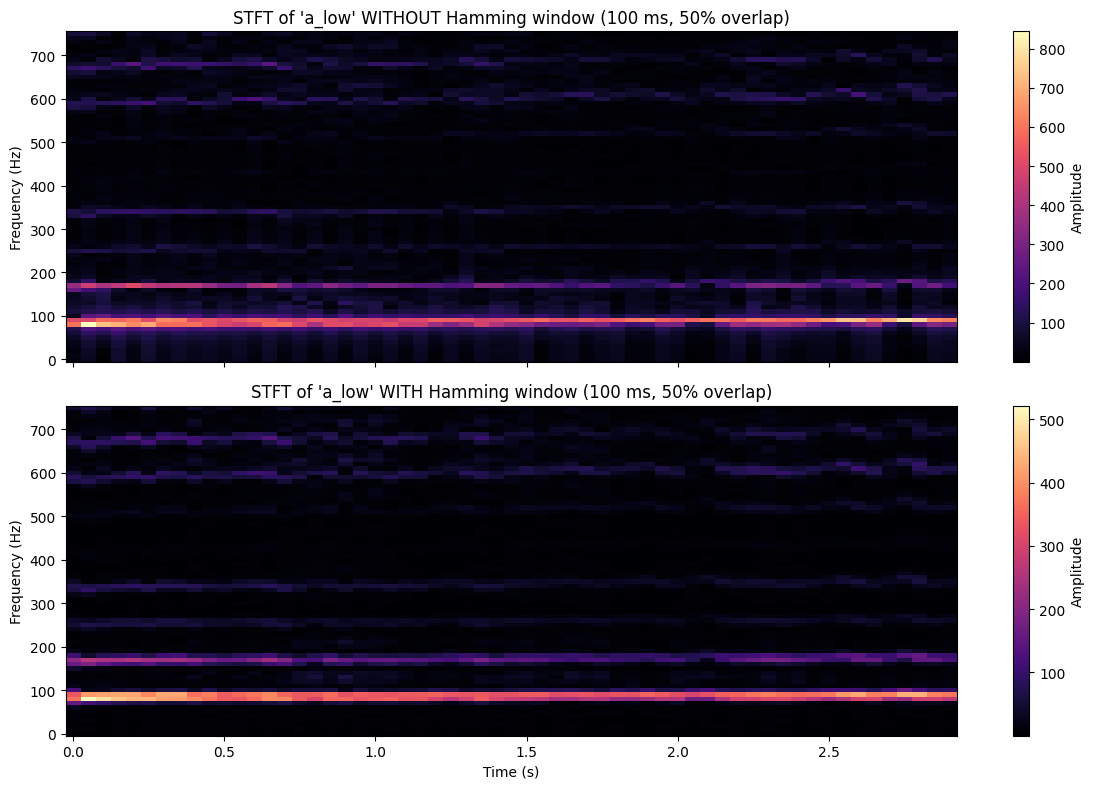

In [36]:
plot_stft(*signals["a_low"], "a_low", window_ms=5, overlap_pct=0.5)
plot_stft(*signals["a_low"], "a_low", window_ms=20, overlap_pct=0.5)
plot_stft(*signals["a_low"], "a_low", window_ms=100, overlap_pct=0.5)

### 3. Vpliv dolžine intervalov na razlikovanje samoglasnikov
Razlikovanje samoglasnikov postane jasnejše z daljšimi intervali zaradi boljše ločljivosti formantov, vendar zelo dolgi intervali lahko zameglijo prehode v dinamični govorni signal.

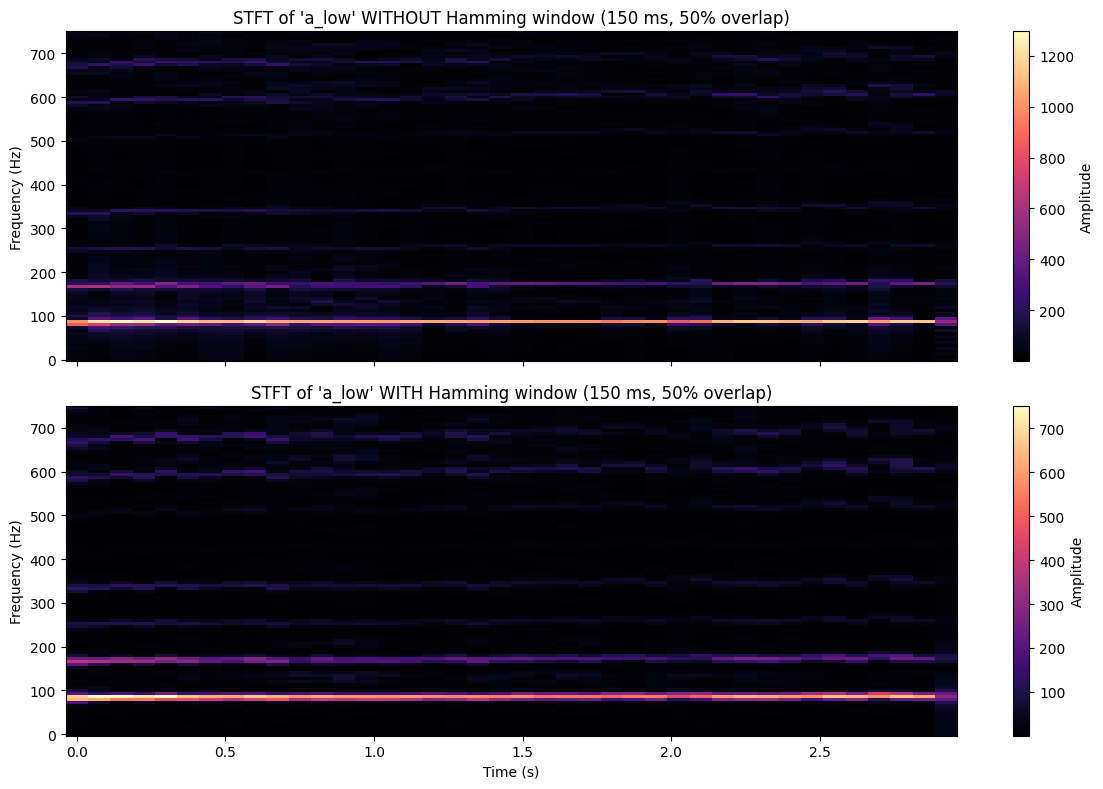

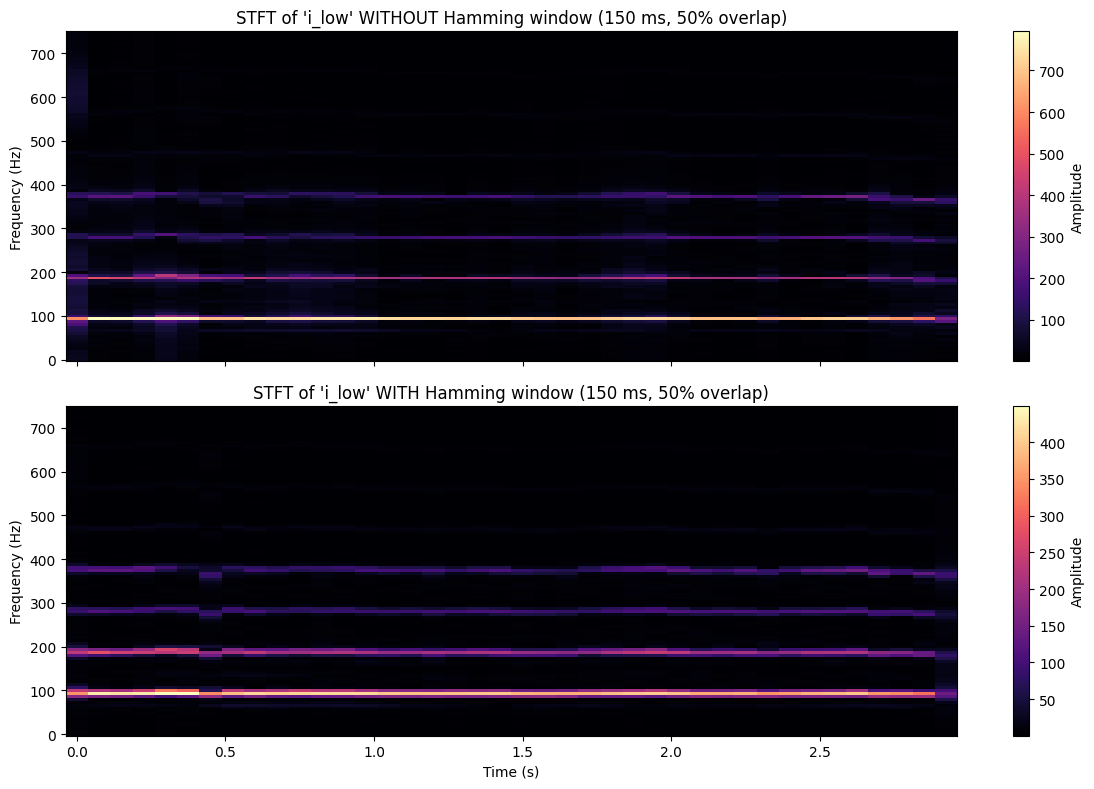

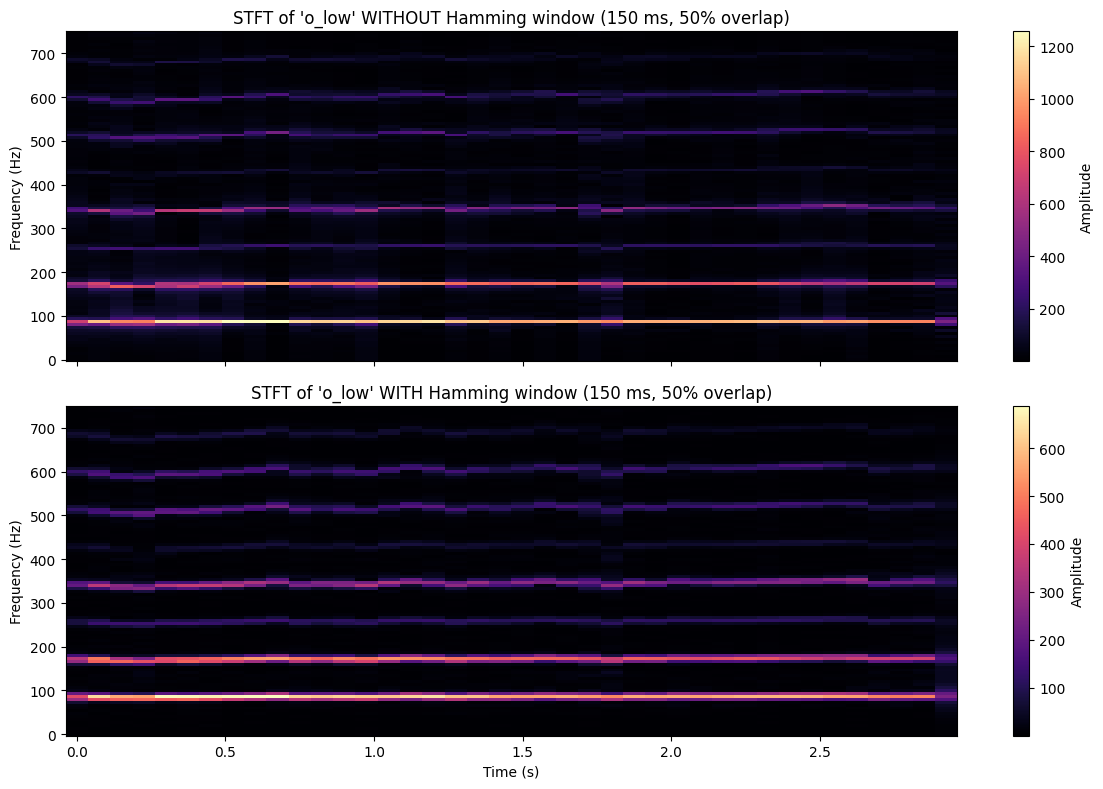

In [43]:
plot_stft(*signals["a_low"], "a_low", window_ms=150, overlap_pct=0.5)
plot_stft(*signals["i_low"], "i_low", window_ms=150, overlap_pct=0.5)
plot_stft(*signals["o_low"], "o_low", window_ms=150, overlap_pct=0.5)


## Zaključek

Analiza je pokazala, da izbira dolžine časovnega okna in stopnje prekrivanja pomembno vpliva na kakovost časovno-frekvenčne predstavitve govora. Krajša okna bolje zaznajo hitro spreminjajoče se komponente, medtem ko daljša okna nudijo boljšo frekvenčno ločljivost in jasnejšo sliko harmonikov. Hitrejša izgovorjava zahteva krajša okna z večjim prekrivanjem, medtem ko je za razlikovanje samoglasnikov bolj primerna uporaba daljših oken.

Za optimalno STFT analizo govora je torej ključno iskanje ravnotežja med časovno in frekvenčno ločljivostjo glede na konkreten primer in analitski cilj.